In [11]:
pip install plotly

  Stored in directory: C:\Users\vinee\AppData\Local\pip\Cache\wheels\d7\a9\33\acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying
Note: you may need to restart the kernel to use updated packages.


In [135]:
import re, nltk
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import joblib
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.offline as offline



import holidays
import datetime
from io import StringIO
from workalendar.europe import Belgium

import warnings
warnings.filterwarnings("ignore")

In [136]:
df = pd.read_csv("export jatin 0929.csv", encoding = "ISO-8859-1")

In [137]:
def holiday(rev):
    
    cal = Belgium()
    holiday = cal.is_working_day(rev)
    return holiday

def VehicleType(column):
    if column == 'SCOOTER':
        return 'Scooter'
    elif column == 'OKAI Kickscooter' or column == 'KICKSCOOTER':
        return 'Kickscooter'
    else:
        return 'Car'
    
def CarGroup(column):
    if column == 'IBIZA - All' or column == 'CORSA - Brussels':
        return 'Combustion cars'
    elif column == 'CITIGO - Antwerp' or column == 'MII - Antwerp' or column == 'G-TRON' or column == 'E-GOLF':       
        return 'Evs'
    else:
        return 'Non-Cars'
    
def Assets(column):
    if column == 'Scooter' or column == 'Kickscooter':
        return 'Soft Assets'
    else:        
        return 'Cars'   
    
def ActualRide(column):
    if column > 200:
        return column
    else:
        return 'technical Issue' 
    
def DistanceConverter(column):
    if column < 4000:
        return 1
    else:
        return 0

In [138]:
df['inputDate'] = pd.to_datetime(df['start_date'])
df['is working'] = df.inputDate.apply(holiday)

In [139]:
df['Vehicle Type'] = df['name'].apply(VehicleType)
df['Car Group'] = df['name'].apply(CarGroup)
df['Assets'] = df['Vehicle Type'].apply(Assets)

In [140]:
archieved = ['t']
status = ['SUSPENDED']
Cancelled_ride = ['t']

df = df[~df['is_archived'].isin(archieved)]
df = df[~df['account_status'].isin(status)]
df = df[~df['is_cancel'].isin(Cancelled_ride)]

In [141]:
df['distance'] = df['distance'].apply(ActualRide)
false_ride = ['technical Issue']
df = df[~df['distance'].isin(false_ride)]

undefined_gender = ['UNDEFINED']
df = df[~df['gender'].isin(undefined_gender)]

In [142]:
dataset = pd.read_csv("test1.csv", encoding = "ISO-8859-1")

In [143]:
dataset['distance'] = dataset['distance'].apply(DistanceConverter)

In [144]:
categorical_features = ['gender', 'vehicleModel', 'vehicleStatus','zone_start','is working']

In [145]:
final_data = pd.get_dummies(dataset, columns = categorical_features)
print(final_data.info())
print(final_data.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146226 entries, 0 to 146225
Data columns (total 24 columns):
age                              146226 non-null int64
duration_new                     146226 non-null int64
distance                         146226 non-null int64
zone_end                         146226 non-null object
city[1]                          146226 non-null object
Vehicle Type                     146226 non-null object
Car Group                        146226 non-null object
Assets                           146226 non-null object
gender_FEMALE                    146226 non-null uint8
gender_MALE                      146226 non-null uint8
vehicleModel_CITIGO - Antwerp    146226 non-null uint8
vehicleModel_CORSA - Brussels    146226 non-null uint8
vehicleModel_IBIZA - All         146226 non-null uint8
vehicleModel_MII - Antwerp       146226 non-null uint8
vehicleModel_OKAI Kickscooter    146226 non-null uint8
vehicleModel_SCOOTER             146226 non-null uint8
vehi

In [146]:
corrs = final_data.corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
offline.plot(figure,filename='corrheatmap.html')

'corrheatmap.html'

In [147]:
X = final_data.drop(['distance','Assets','Vehicle Type','Car Group','city[1]','zone_end'],axis = 1)

In [148]:
Y = final_data['distance'] # Labels
print(type(X))
print(type(Y))
print(X.shape)
print(Y.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(146226, 18)
(146226,)


In [149]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146226 entries, 0 to 146225
Data columns (total 18 columns):
age                              146226 non-null int64
duration_new                     146226 non-null int64
gender_FEMALE                    146226 non-null uint8
gender_MALE                      146226 non-null uint8
vehicleModel_CITIGO - Antwerp    146226 non-null uint8
vehicleModel_CORSA - Brussels    146226 non-null uint8
vehicleModel_IBIZA - All         146226 non-null uint8
vehicleModel_MII - Antwerp       146226 non-null uint8
vehicleModel_OKAI Kickscooter    146226 non-null uint8
vehicleModel_SCOOTER             146226 non-null uint8
vehicleStatus_available          146226 non-null uint8
vehicleStatus_maintenance        146226 non-null uint8
zone_start_Antwerp               146226 non-null uint8
zone_start_Brussels              146226 non-null uint8
zone_start_Charleroi             146226 non-null uint8
zone_start_Zaventem              146226 non-null uint8
is workin

In [150]:
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)

# Dividing dataset into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split( X_scaled, Y, test_size = 0.3, random_state = 100)

print(X_train.shape)
print(X_test.shape)

(102358, 18)
(43868, 18)


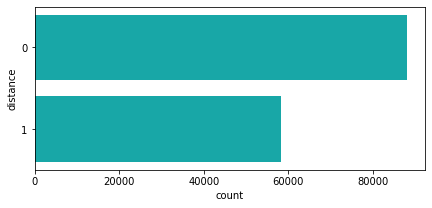

In [151]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y="distance", data=final_data, color="c")

In [152]:
print("Number of observations in each class before oversampling (training data): \n", pd.Series(Y_train).value_counts())

Number of observations in each class before oversampling (training data): 
 0    61453
1    40905
Name: distance, dtype: int64


In [153]:
smote = SMOTE(random_state = 101)
X_train,Y_train = smote.fit_sample(X_train,Y_train)

print("Number of observations in each class after oversampling (training data): \n", pd.Series(Y_train).value_counts())

Number of observations in each class after oversampling (training data): 
 1    61453
0    61453
Name: distance, dtype: int64


In [301]:
# Tuning the random forest parameter 'n_estimators' and implementing cross-validation using Grid Search
rfc = RandomForestClassifier(criterion='entropy', max_features='auto', random_state=1)
grid_param = {'n_estimators': [550,600,650,700]}

gd_sr = GridSearchCV(estimator=rfc, param_grid=grid_param, scoring='recall', cv=5)

"""
In the above GridSearchCV(), scoring parameter should be set as follows:
scoring = 'accuracy' when you want to maximize prediction accuracy
scoring = 'recall' when you want to minimize false negatives
scoring = 'precision' when you want to minimize false positives
scoring = 'f1' when you want to balance false positives and false negatives (place equal emphasis on minimizing both)
"""

gd_sr.fit(X_train, Y_train)

best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

{'n_estimators': 600}
0.8592204238548188


duration_new                     0.797510
age                              0.119573
vehicleModel_OKAI Kickscooter    0.023530
vehicleModel_SCOOTER             0.020224
vehicleModel_IBIZA - All         0.010342
vehicleModel_CORSA - Brussels    0.007781
vehicleModel_MII - Antwerp       0.004055
vehicleModel_CITIGO - Antwerp    0.002901
zone_start_Antwerp               0.002441
zone_start_Brussels              0.002112
is working_True                  0.001557
gender_FEMALE                    0.001527
is working_False                 0.001510
gender_MALE                      0.001508
vehicleStatus_maintenance        0.001150
vehicleStatus_available          0.001143
zone_start_Zaventem              0.001023
zone_start_Charleroi             0.000114
dtype: float64
Classification report: 
               precision    recall  f1-score   support

           0       0.88      0.87      0.87     26479
           1       0.80      0.82      0.81     17389

    accuracy                           0

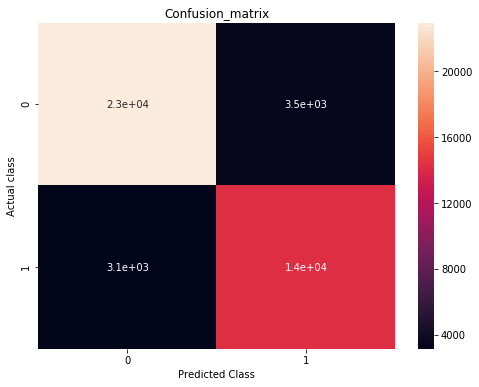

Confusion matrix: 
 [[22963  3516]
 [ 3133 14256]]
TP:  14256
TN:  22963
FP:  3516
FN:  3133


In [123]:
rfc = RandomForestClassifier(n_estimators=600, criterion='entropy', max_features='auto', random_state=1)
rfc.fit(X_train,Y_train)
featimp = pd.Series(rfc.feature_importances_, index=list(X)).sort_values(ascending=False)
print(featimp)

Y_pred = rfc.predict(X_test)
print('Classification report: \n', metrics.classification_report(Y_test, Y_pred))

conf_mat = metrics.confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

Classification report: 
               precision    recall  f1-score   support

           0       0.88      0.87      0.87     26479
           1       0.80      0.82      0.81     17389

    accuracy                           0.85     43868
   macro avg       0.84      0.84      0.84     43868
weighted avg       0.85      0.85      0.85     43868



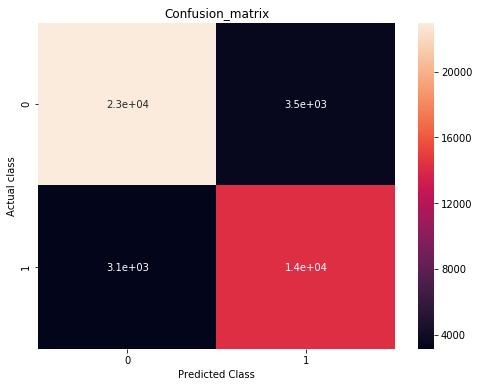

Confusion matrix: 
 [[22984  3495]
 [ 3132 14257]]
TP:  14257
TN:  22984
FP:  3495
FN:  3132


In [126]:
X1 = final_data[['duration_new', 'age', 'vehicleModel_OKAI Kickscooter', 'vehicleModel_SCOOTER', 'vehicleModel_IBIZA - All','vehicleModel_CORSA - Brussels','vehicleModel_MII - Antwerp','vehicleModel_CITIGO - Antwerp','zone_start_Antwerp','zone_start_Brussels','is working_True','is working_False','gender_FEMALE','gender_MALE','vehicleStatus_available','vehicleStatus_maintenance']]

feature_scaler = StandardScaler()
X1_scaled = feature_scaler.fit_transform(X1)

X1_train, X1_test, Y1_train, Y1_test = train_test_split( X1_scaled, Y, test_size = 0.3, random_state = 100)

smote = SMOTE(random_state = 101)
X1_train,Y1_train = smote.fit_sample(X1_train,Y1_train)

rfc = RandomForestClassifier(n_estimators=400, criterion='entropy', max_features='auto', random_state=1)
rfc.fit(X1_train,Y1_train)

Y_pred = rfc.predict(X1_test)
print('Classification report: \n', metrics.classification_report(Y1_test, Y_pred))

conf_mat = metrics.confusion_matrix(Y1_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

In [27]:
abc = AdaBoostClassifier(random_state=1)
grid_param = {'n_estimators': [5,6,7,8,9,10,11]}

gd_sr = GridSearchCV(estimator=abc, param_grid=grid_param, scoring='recall', cv=5)

"""
In the above GridSearchCV(), scoring parameter should be set as follows:
scoring = 'accuracy' when you want to maximize prediction accuracy
scoring = 'recall' when you want to minimize false negatives
scoring = 'precision' when you want to minimize false positives
scoring = 'f1' when you want to balance false positives and false negatives (place equal emphasis on minimizing both)
"""

gd_sr.fit(X_train, Y_train)

best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

{'n_estimators': 6}
0.852738245679482


duration_new                     0.833333
vehicleModel_OKAI Kickscooter    0.166667
is working_False                 0.000000
gender_FEMALE                    0.000000
gender_MALE                      0.000000
vehicleModel_CITIGO - Antwerp    0.000000
vehicleModel_CORSA - Brussels    0.000000
vehicleModel_IBIZA - All         0.000000
vehicleModel_MII - Antwerp       0.000000
is working_True                  0.000000
vehicleModel_SCOOTER             0.000000
vehicleStatus_available          0.000000
vehicleStatus_maintenance        0.000000
zone_start_Antwerp               0.000000
zone_start_Brussels              0.000000
zone_start_Charleroi             0.000000
zone_start_Zaventem              0.000000
age                              0.000000
dtype: float64
Classification report: 
               precision    recall  f1-score   support

           0       0.90      0.89      0.90     26479
           1       0.84      0.84      0.84     17389

    accuracy                           0

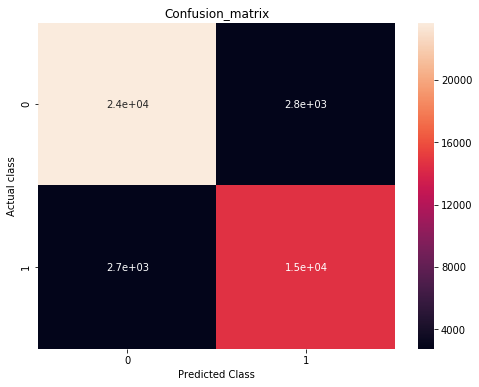

Confusion matrix: 
 [[23676  2803]
 [ 2739 14650]]
TP:  14650
TN:  23676
FP:  2803
FN:  2739


In [127]:
abc = AdaBoostClassifier(n_estimators=6, random_state=1)
abc.fit(X_train,Y_train)
featimp = pd.Series(abc.feature_importances_, index=list(X)).sort_values(ascending=False)
print(featimp)

Y_pred = abc.predict(X_test)
print('Classification report: \n', metrics.classification_report(Y_test, Y_pred))

conf_mat = metrics.confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

In [154]:
gbc = GradientBoostingClassifier(random_state=1)

grid_param = {'n_estimators': [30,40,50,60], 'max_depth' : [9,10,11,12], 'max_leaf_nodes': [24,28,32]}

gd_sr = GridSearchCV(estimator=gbc, param_grid=grid_param, scoring='recall', cv=5)

"""
In the above GridSearchCV(), scoring parameter should be set as follows:
scoring = 'accuracy' when you want to maximize prediction accuracy
scoring = 'recall' when you want to minimize false negatives
scoring = 'precision' when you want to minimize false positives
scoring = 'f1' when you want to balance false positives and false negatives (place equal emphasis on minimizing both)
"""

gd_sr.fit(X_train, Y_train)

best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

{'max_depth': 12, 'max_leaf_nodes': 32, 'n_estimators': 50}
0.8532376842846568


duration_new                     0.970626
vehicleModel_OKAI Kickscooter    0.007974
age                              0.006704
zone_start_Brussels              0.003178
vehicleModel_MII - Antwerp       0.002443
vehicleModel_SCOOTER             0.002247
vehicleModel_CITIGO - Antwerp    0.001867
gender_MALE                      0.001746
gender_FEMALE                    0.001440
vehicleModel_CORSA - Brussels    0.000575
zone_start_Zaventem              0.000316
vehicleModel_IBIZA - All         0.000314
is working_False                 0.000194
is working_True                  0.000185
zone_start_Antwerp               0.000144
zone_start_Charleroi             0.000033
vehicleStatus_available          0.000016
vehicleStatus_maintenance        0.000000
dtype: float64
Classification report: 
               precision    recall  f1-score   support

           0       0.90      0.90      0.90     26479
           1       0.85      0.85      0.85     17389

    accuracy                           0

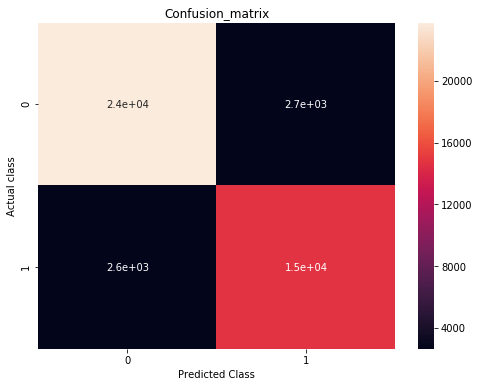

Confusion matrix: 
 [[23775  2704]
 [ 2636 14753]]
TP:  14753
TN:  23775
FP:  2704
FN:  2636


In [129]:
gbc = GradientBoostingClassifier(n_estimators=50, max_depth=11, max_leaf_nodes=24, random_state=1)
gbc.fit(X_train,Y_train)
featimp = pd.Series(gbc.feature_importances_, index=list(X)).sort_values(ascending=False)
print(featimp)

Y_pred = gbc.predict(X_test)
print('Classification report: \n', metrics.classification_report(Y_test, Y_pred))

conf_mat = metrics.confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

In [ ]:
grid_predictions = grid.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, grid_predictions))


In [16]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install --upgrade xgboost

Requirement already up-to-date: xgboost in c:\users\vinee\anaconda3\lib\site-packages (1.3.0.post0)
Note: you may need to restart the kernel to use updated packages.


In [19]:
param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['binary:logistic']
    }

xgb_model = XGBClassifier()

gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           scoring='recall',
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

gsearch.fit(X_train, Y_train)

best_parameters = gsearch.best_params_
print(best_parameters)

best_result = gsearch.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 37.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 96.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 166.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 267.7min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 328.1min finished


[04:19:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 100, 'objective': 'binary:logistic', 'subsample': 0.5}
0.8597562460847257


[12:31:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
vehicleModel_OKAI Kickscooter    0.238890
duration_new                     0.196603
zone_start_Zaventem              0.104946
vehicleModel_CORSA - Brussels    0.092223
vehicleModel_CITIGO - Antwerp    0.066534
vehicleModel_SCOOTER             0.053066
vehicleModel_IBIZA - All         0.050434
vehicleModel_MII - Antwerp       0.049568
zone_start_Charleroi             0.032488
zone_start_Brussels              0.018366
gender_MALE                      0.015154
age                              0.014077
zone_start_Antwerp               0.013767
gender_FEMALE                    0.013740
is working_False                 0.010502
is working_True                  0.010086
vehicleStatus_avai

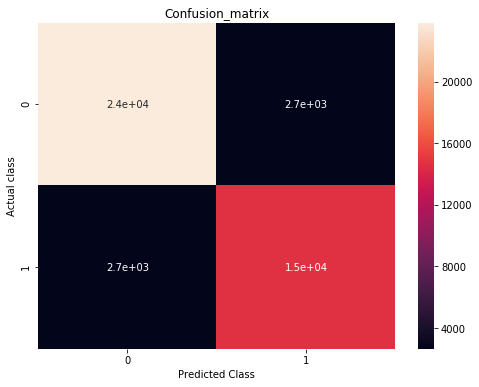

Confusion matrix: 
 [[23823  2656]
 [ 2681 14708]]
TP:  14708
TN:  23823
FP:  2656
FN:  2681


In [130]:
xgb = XGBClassifier(n_estimators=100, colsample_bytree=0.7, learning_rate=0.1, max_depth = 10, min_child_weight = 5, objective = 'binary:logistic', subsample = 0.5,random_state=1)
xgb.fit(X_train,Y_train)
featimp = pd.Series(xgb.feature_importances_, index=list(X)).sort_values(ascending=False)
print(featimp)

Y_pred = xgb.predict(X_test)
print('Classification report: \n', metrics.classification_report(Y_test, Y_pred))

conf_mat = metrics.confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

In [16]:


lgbm = LGBMClassifier(random_state=1)

grid_param = {'num_leaves': [127,200],
    'reg_alpha': [0, 0.1, 0.5],
    'min_data_in_leaf': [300, 400,450,500],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]}

gd_sr = GridSearchCV(estimator=lgbm, param_grid=grid_param, scoring='recall', cv=5)

"""
In the above GridSearchCV(), scoring parameter should be set as follows:
scoring = 'accuracy' when you want to maximize prediction accuracy
scoring = 'recall' when you want to minimize false negatives
scoring = 'precision' when you want to minimize false positives
scoring = 'f1' when you want to balance false positives and false negatives (place equal emphasis on minimizing both)
"""

gd_sr.fit(X_train, Y_train)

best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

{'lambda_l1': 0, 'lambda_l2': 1, 'min_data_in_leaf': 400, 'num_leaves': 200, 'reg_alpha': 0}
0.8598049513187809


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
age                              6841
duration_new                     6555
vehicleModel_SCOOTER              598
zone_start_Brussels               500
is working_True                   486
vehicleModel_IBIZA - All          469
gender_FEMALE                     434
zone_start_Antwerp                347
vehicleModel_OKAI Kickscooter     300
vehicleModel_MII - Antwerp        287
vehicleModel_CORSA - Brussels     284
vehicleModel_CITIGO - Antwerp     194
vehicleStatus_available           159
gender_MALE                        36
vehicleStatus_maintenance           7
zone_start_Charleroi                0
is working_False                    0
zone_start_Zaventem              

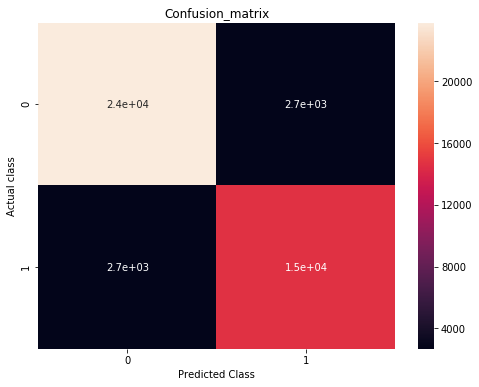

Confusion matrix: 
 [[23807  2672]
 [ 2675 14714]]
TP:  14714
TN:  23807
FP:  2672
FN:  2675


In [131]:
lgbm = LGBMClassifier(lambda_l1=0, lambda_l2=1, learning_rate=0.1, min_data_in_leaf = 400, num_leaves = 200, reg_alpha = 0,random_state=1)
lgbm.fit(X_train,Y_train)
featimp = pd.Series(lgbm.feature_importances_, index=list(X)).sort_values(ascending=False)
print(featimp)

Y_pred = lgbm.predict(X_test)
print('Classification report: \n', metrics.classification_report(Y_test, Y_pred))

conf_mat = metrics.confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

In [21]:


logreg = LogisticRegression(random_state=1)

grid_param = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

gd_sr = GridSearchCV(estimator=logreg, param_grid=grid_param, scoring='recall', cv=5)

"""
In the above GridSearchCV(), scoring parameter should be set as follows:
scoring = 'accuracy' when you want to maximize prediction accuracy
scoring = 'recall' when you want to minimize false negatives
scoring = 'precision' when you want to minimize false positives
scoring = 'f1' when you want to balance false positives and false negatives (place equal emphasis on minimizing both)
"""

gd_sr.fit(X_train, Y_train)

best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

{'C': 100.0, 'penalty': 'l2'}
0.8759038230494725


Classification report: 
               precision    recall  f1-score   support

           0       0.90      0.79      0.84     26479
           1       0.73      0.86      0.79     17389

    accuracy                           0.82     43868
   macro avg       0.81      0.83      0.82     43868
weighted avg       0.83      0.82      0.82     43868



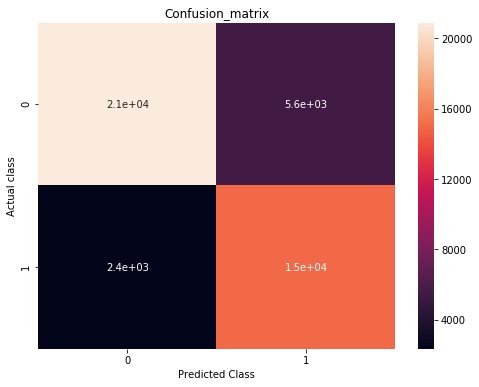

Confusion matrix: 
 [[20899  5580]
 [ 2353 15036]]
TP:  15036
TN:  20899
FP:  5580
FN:  2353


In [132]:
logreg = LogisticRegression(C=100.0, penalty='l2',random_state=1)
logreg.fit(X_train,Y_train)
#featimp = pd.Series(logreg.feature_importances_, index=list(X)).sort_values(ascending=False)
#print(featimp)



Y_pred = logreg.predict(X_test)
print('Classification report: \n', metrics.classification_report(Y_test, Y_pred))

conf_mat = metrics.confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

In [133]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(activation = 'linear'):
# define the keras model
    model = Sequential()
    model.add(Dense(12, input_dim=18, kernel_initializer='uniform', activation='linear'))
    model.add(Dense(8, activation='linear'))
    model.add(Dense(1,kernel_initializer='uniform', activation='sigmoid'))

# compile the keras model
    km = model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10)

# fit the keras model on the dataset
kn = model.fit(X_train,Y_train)

Epoch 1/150
12291/12291 [==============================] - 9s 768us/step - loss: 0.5581 - accuracy: 0.7758
Epoch 2/150
12291/12291 [==============================] - 9s 750us/step - loss: 0.5395 - accuracy: 0.8055
Epoch 3/150
12291/12291 [==============================] - 9s 751us/step - loss: 0.5382 - accuracy: 0.8187
Epoch 4/150
12291/12291 [==============================] - 9s 756us/step - loss: 0.5339 - accuracy: 0.8025
Epoch 5/150
12291/12291 [==============================] - 9s 765us/step - loss: 0.5392 - accuracy: 0.8208
Epoch 6/150
12291/12291 [==============================] - 9s 761us/step - loss: 0.5386 - accuracy: 0.8195
Epoch 7/150
12291/12291 [==============================] - 9s 756us/step - loss: 0.5382 - accuracy: 0.8153
Epoch 8/150
12291/12291 [==============================] - 9s 762us/step - loss: 0.5325 - accuracy: 0.8091
Epoch 9/150
12291/12291 [==============================] - 9s 755us/step - loss: 0.5378 - accuracy: 0.8181
Epoch 10/150
12291/12291 [===========

12291/12291 [==============================] - 9s 743us/step - loss: 0.5342 - accuracy: 0.8241
Epoch 77/150
12291/12291 [==============================] - 10s 802us/step - loss: 0.5390 - accuracy: 0.8319
Epoch 78/150
12291/12291 [==============================] - 9s 747us/step - loss: 0.5290 - accuracy: 0.8274
Epoch 79/150
12291/12291 [==============================] - 9s 745us/step - loss: 0.5336 - accuracy: 0.8238
Epoch 80/150
12291/12291 [==============================] - 9s 753us/step - loss: 0.5371 - accuracy: 0.8304
Epoch 81/150
12291/12291 [==============================] - 9s 744us/step - loss: 0.5357 - accuracy: 0.8328
Epoch 82/150
12291/12291 [==============================] - 9s 752us/step - loss: 0.5341 - accuracy: 0.8238
Epoch 83/150
12291/12291 [==============================] - 9s 748us/step - loss: 0.5329 - accuracy: 0.8218
Epoch 84/150
12291/12291 [==============================] - 9s 743us/step - loss: 0.5368 - accuracy: 0.8315
Epoch 85/150
12291/12291 [==============

Classification report: 
               precision    recall  f1-score   support

           0       0.90      0.79      0.84     26479
           1       0.73      0.87      0.79     17389

    accuracy                           0.82     43868
   macro avg       0.82      0.83      0.82     43868
weighted avg       0.83      0.82      0.82     43868



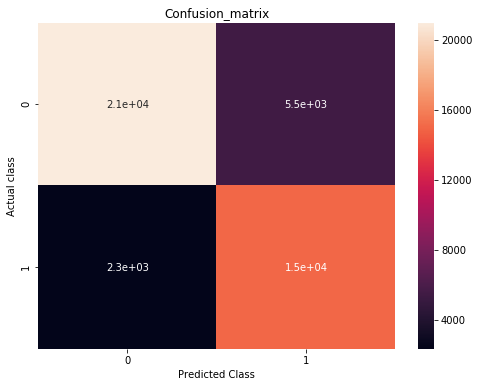

Confusion matrix: 
 [[20986  5493]
 [ 2342 15047]]
TP:  15047
TN:  20986
FP:  5493
FN:  2342


In [134]:
Y_pred = model.predict(X_test)
print('Classification report: \n', metrics.classification_report(Y_test, Y_pred))

conf_mat = metrics.confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])